In [25]:
%load_ext autoreload
%autoreload 2
#os.environ["OMP_NUM_THREADS"] = str(os.cpu_count() // 2)
#os.environ["GOMP_CPU_AFFINITY"] = "granularity=core,compact"
from Scripts.model import *
from Scripts.loss import *
from Scripts.results_manager import *
from Scripts.plots import *
from Scripts.dataset import *
from Scripts.trainer import *
from Scripts.inference import *
from Scripts.Onnx_Class import *
from Scripts.lr_finder import *
from Scripts.generate_configs import *
#from Scripts.asymmetric_model import *
from Scripts.generate_asymmetric_configs import *
from Scripts.excecute import *
from Scripts.quantize import *
from Scripts.upload_summaries import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
config_path = "Configs"

In [ ]:
training_selected_class(config_path, 'grid')
metrics_to_db()

In [ ]:
training_all_classes(config_path)
metrics_to_db()

In [ ]:
training_run_folder = "Training_Runs"
inference_output_dir = "Inference_Runs"

inference_model(training_run_folder, inference_output_dir)

Anomalie-Score für das Bild: 0.0072247846983373165


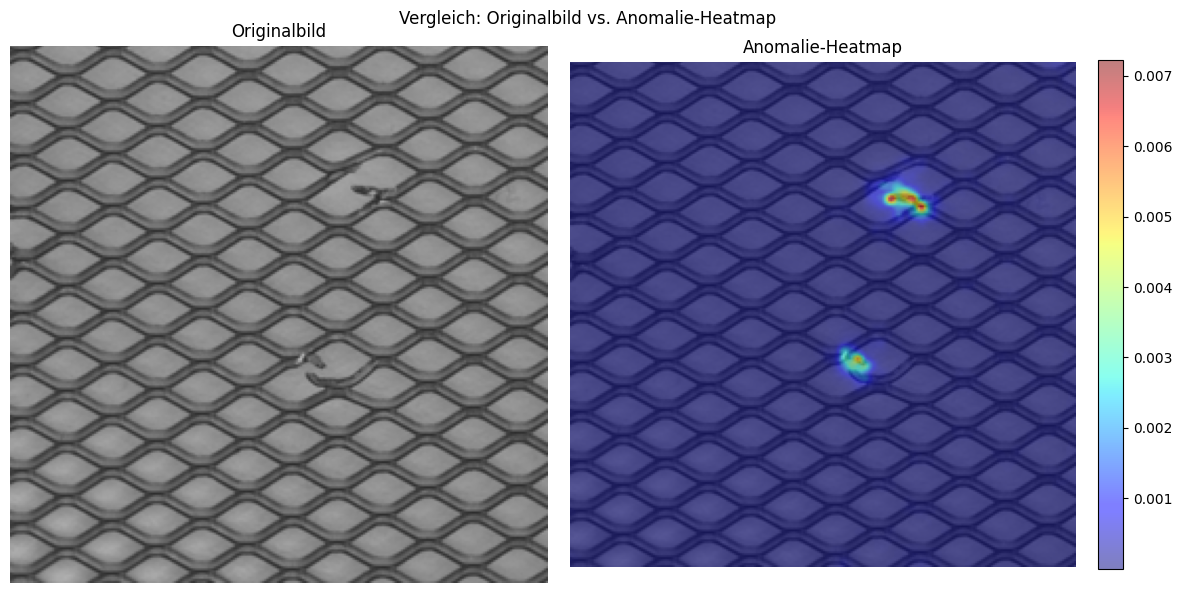

Anomalie-Score für das Bild: 0.006944378837943077


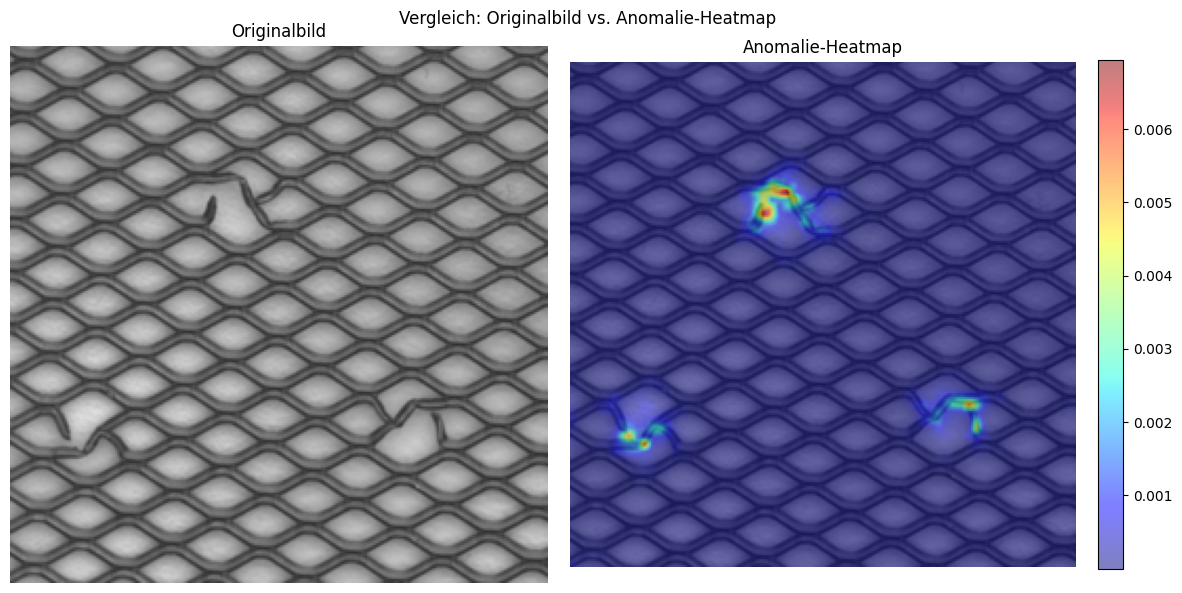

Anomalie-Score für das Bild: 0.004742999095469713


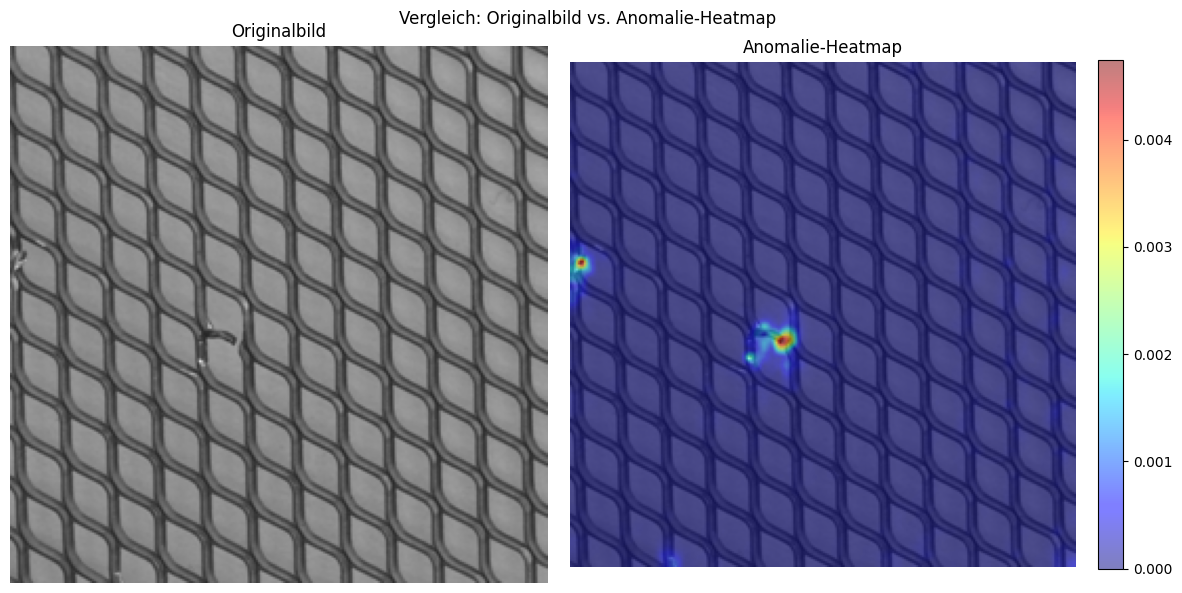

Anomalie-Score für das Bild: 0.007029423024505377


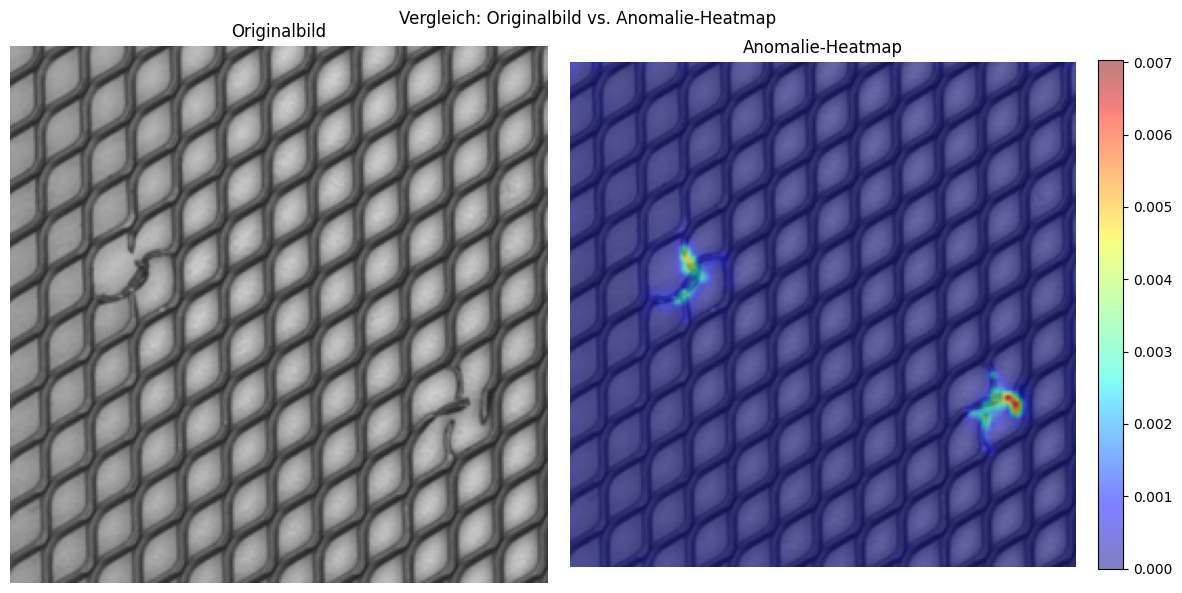

Anomalie-Score für das Bild: 0.012315710075199604


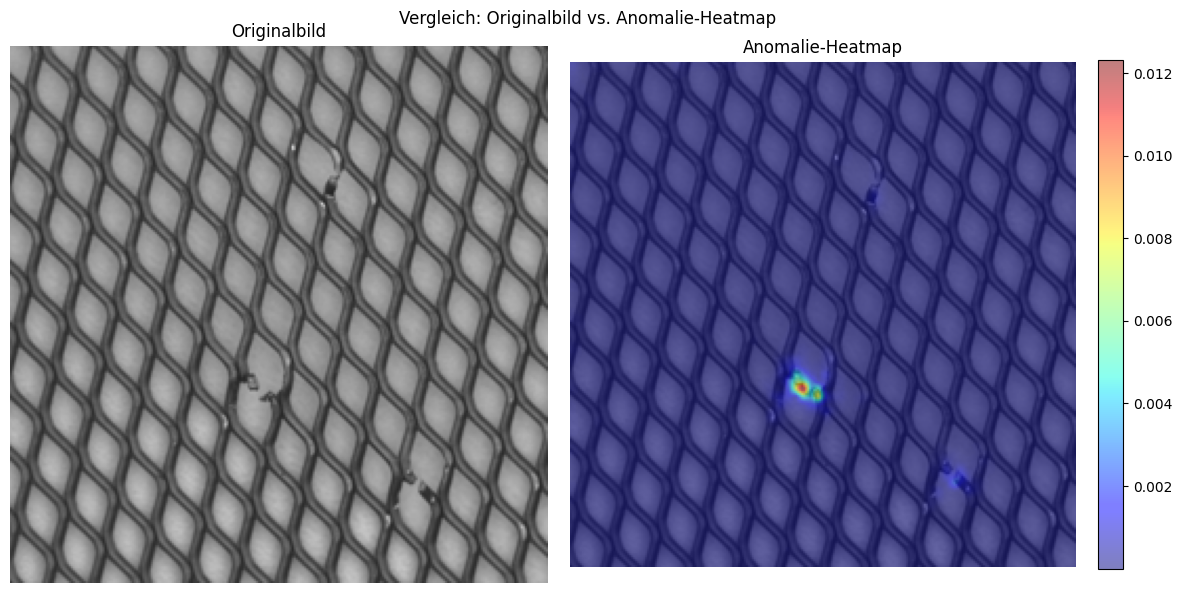

Anomalie-Score für das Bild: 0.0034703270066529512


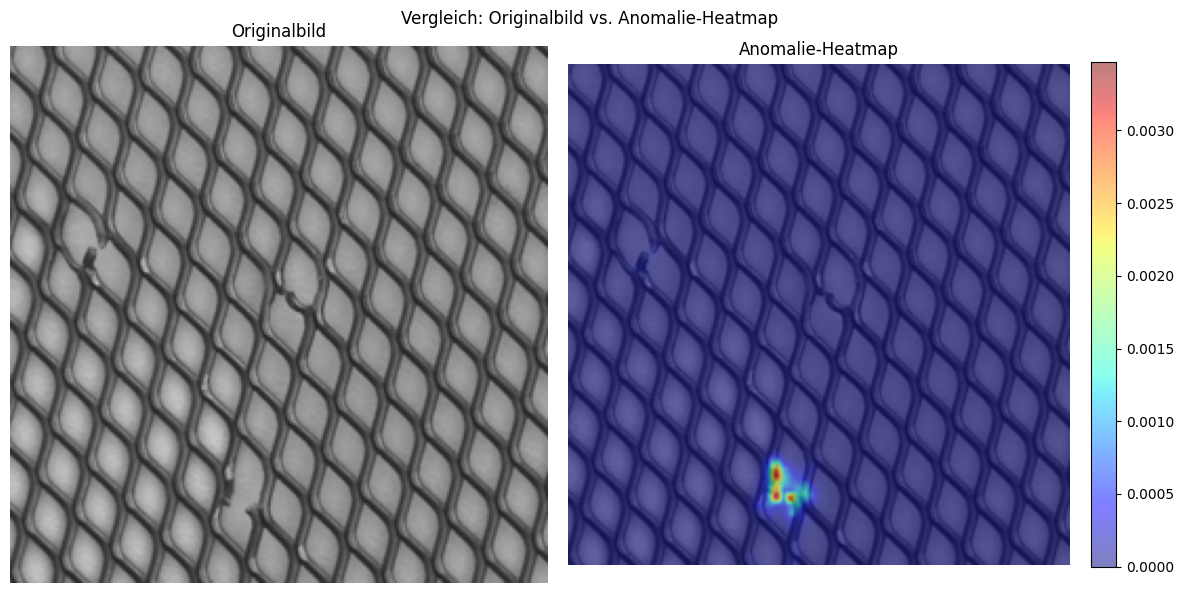

Anomalie-Score für das Bild: 0.0031627637799829245


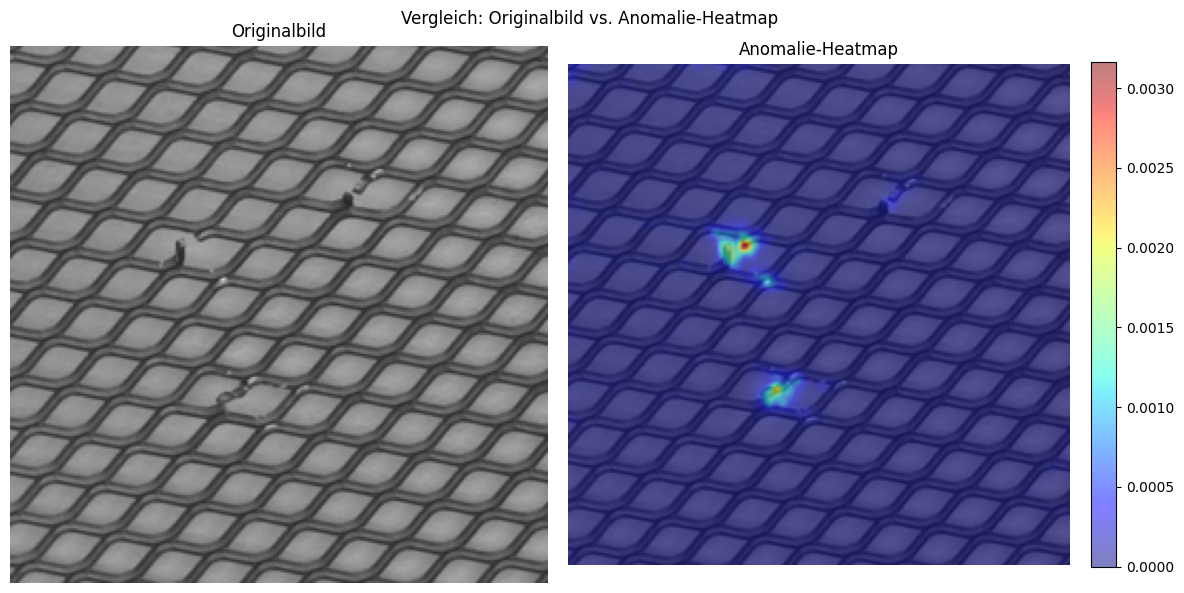

Anomalie-Score für das Bild: 0.0067508709616959095


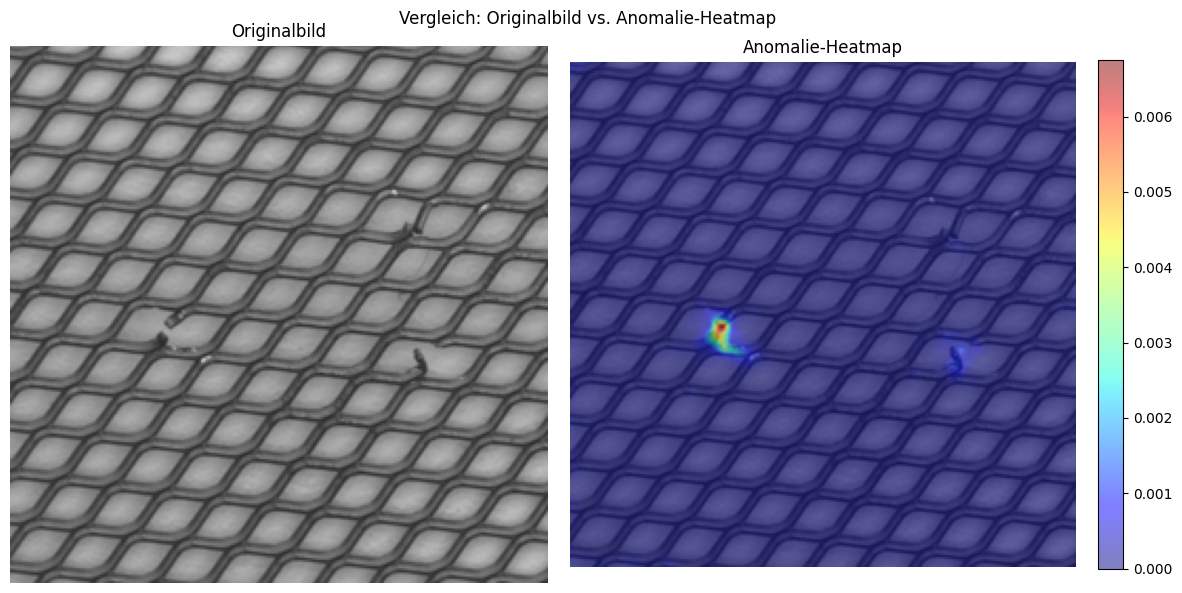

Anomalie-Score für das Bild: 0.00160396215505898


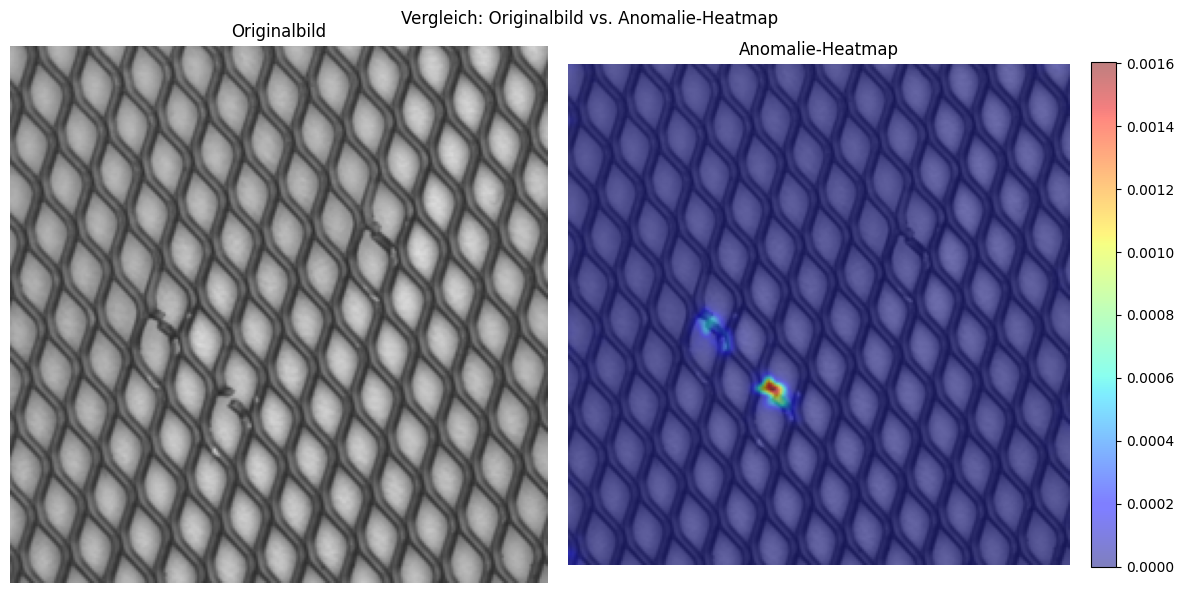

Anomalie-Score für das Bild: 0.01212780736386776


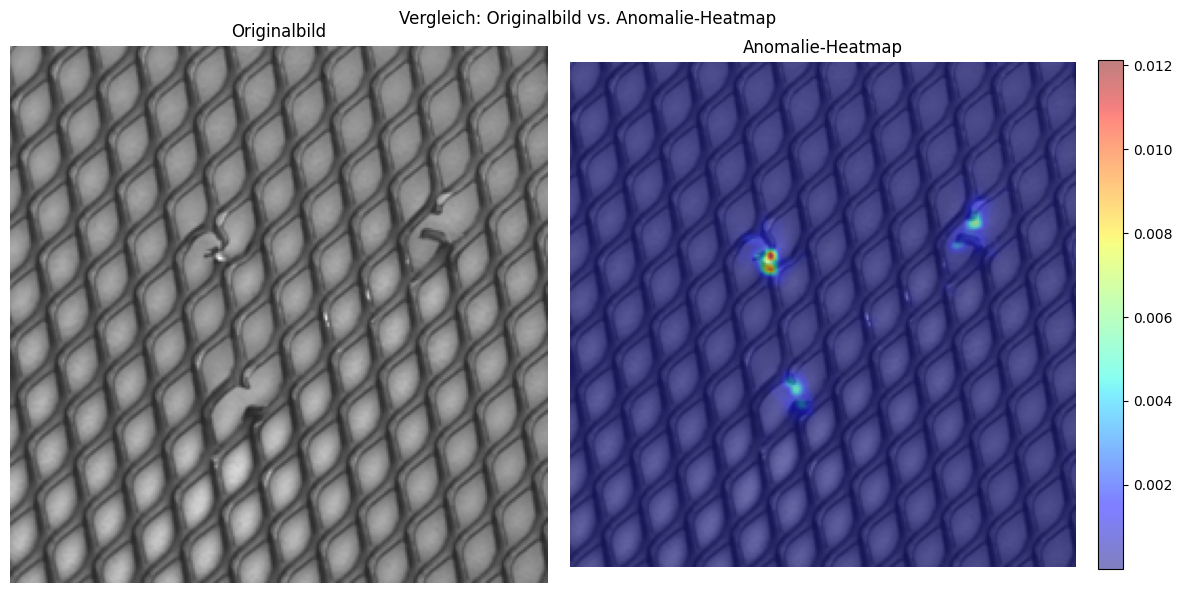

Anomalie-Score für das Bild: 0.005064032506197691


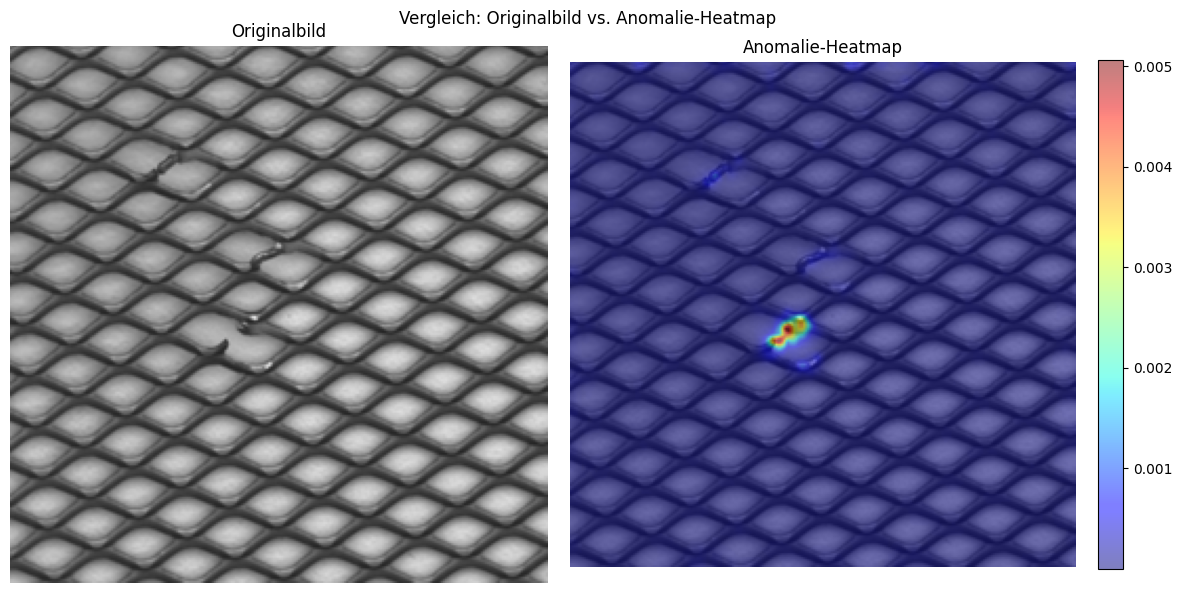

Anomalie-Score für das Bild: 0.00244228751398623


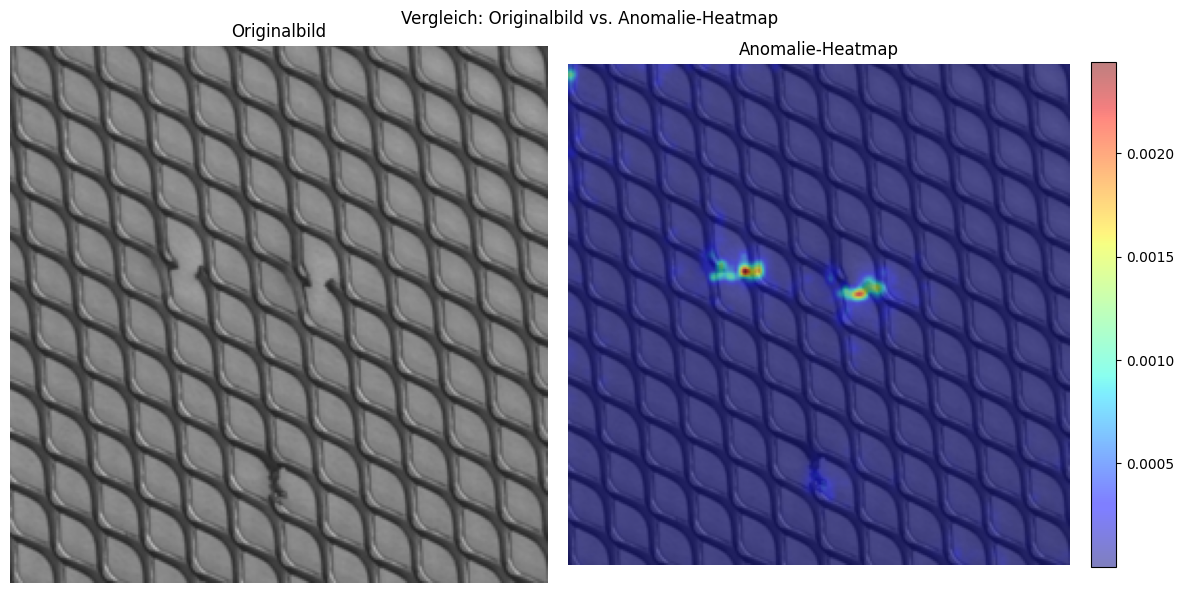

In [23]:
import onnxruntime as ort
import numpy as np
from PIL import Image

# 1. ONNX-Modell laden
onnx_model_path = r"onnx_models\STFPM_mobilenetv4_conv_large.onnx"
sess = ort.InferenceSession(onnx_model_path)

image_path = glob.glob(os.path.join(
    r'Images\grid\test\broken', '*.png'))
for path in image_path:

    # 2. Ein Bild für die Inferenz vorbereiten
    # image_path = r"Images\grid\test\bent\003.png"
    image = Image.open(path).convert("RGB")

    # Resize the image to the expected input size
    img_size = 256
    image = image.resize((img_size, img_size))

    input_data = np.array(image, dtype=np.uint8)
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension

    # 3. Inferenz durchführen
    input_name = sess.get_inputs()[0].name
    outputs = sess.run(None, {input_name: input_data})

    # 4. Ergebnisse auswerten
    anomaly_map = outputs[0]
    anomaly_score = outputs[1]

    print(f"Anomalie-Score für das Bild: {anomaly_score[0]}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 2. Originalbild anzeigen
    axes[0].imshow(image)
    axes[0].set_title("Originalbild")
    axes[0].axis('off')

    # 3. Heatmap über das Originalbild legen
    axes[1].imshow(image)
    heatmap = axes[1].imshow(np.squeeze(anomaly_map), cmap='jet', alpha=0.5)
    axes[1].set_title("Anomalie-Heatmap")
    axes[1].axis('off')

    # 4. Farbbalken für die Heatmap hinzufügen
    fig.colorbar(heatmap, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # 5. Plot anzeigen oder speichern
    plt.suptitle("Vergleich: Originalbild vs. Anomalie-Heatmap")
    plt.show()

In [ ]:
config = load_config(
    r'Training_Runs\MVTecAD_grid\resnet18\2830be19-bea8-41f8-a1e8-1a6ef49b8cbc\STFPM_Config_resnet18.yaml')
with open(r'Training_Runs\MVTecAD_grid\resnet18\2830be19-bea8-41f8-a1e8-1a6ef49b8cbc\summary_metrics.json', 'r') as f:
    summary_metrics = json.load(f)
quantize_model(
    r'Training_Runs\MVTecAD_grid\resnet18\2830be19-bea8-41f8-a1e8-1a6ef49b8cbc\weights\resnet18_grid_2830be19-bea8-41f8-a1e8-1a6ef49b8cbc_best_student.pth',
    config,
    summary_metrics
)

In [26]:
config_paths = glob.glob(os.path.join(
    "Training_Runs", "**", "*.yaml"), recursive=True)
summary_metrics_paths = glob.glob(os.path.join(
    "Training_Runs", "**", "summary_metrics.json"), recursive=True)
best_student_weight_paths = glob.glob(os.path.join(
    "Training_Runs", "**", "*best_student.pth"), recursive=True)
for configs, summary_metrics, best_student_weights in zip(config_paths, summary_metrics_paths, best_student_weight_paths):
    config = load_config(configs)
    summary_metric = load_json(summary_metrics)
    quantize_model(
        best_student_weights,
        config,
        summary_metric
    )

Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


[WARN] Layer 'layer1' nicht gefunden im student_model.
[WARN] Layer 'layer2' nicht gefunden im student_model.
[WARN] Layer 'layer3' nicht gefunden im student_model.
[WARN] Layer 'layer4' nicht gefunden im student_model.
Quantization finished â€” saved to disk.


Unexpected keys (classifier.bias, classifier.weight, conv_head.bias, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


[WARN] Layer 'layer1' nicht gefunden im student_model.
[WARN] Layer 'layer2' nicht gefunden im student_model.
[WARN] Layer 'layer3' nicht gefunden im student_model.
[WARN] Layer 'layer4' nicht gefunden im student_model.
Quantization finished â€” saved to disk.


Unexpected keys (classifier.bias, classifier.weight, conv_head.weight, norm_head.bias, norm_head.num_batches_tracked, norm_head.running_mean, norm_head.running_var, norm_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


[WARN] Layer 'layer1' nicht gefunden im student_model.
[WARN] Layer 'layer2' nicht gefunden im student_model.
[WARN] Layer 'layer3' nicht gefunden im student_model.
[WARN] Layer 'layer4' nicht gefunden im student_model.


KeyboardInterrupt: 

In [ ]:
test_set = MVTecDataset(
    img_size=config['dataset']['img_size'],
    base_path=config['dataset']['base_path'],
    cls=config['dataset']['class'],
    mode='test',
    download_if_missing=False
)
test_loader = DataLoader(
    test_set,
    batch_size=config['dataloader']['batch_size'],
    shuffle=False
)

In [ ]:
torch.backends.quantized.engine = 'fbgemm'

In [ ]:
cpu_device = torch.device("cpu")

base_model_for_loading = STFPM(
    architecture=config['model']['architecture'],
    layers=config['model']['layers']
).to(cpu_device).eval()

model_to_load = QuantizableWrapper(
    base_model_for_loading).to(cpu_device).eval()

fuse_resnet_student_model(model_to_load)

model_to_load.student_model.qconfig = torch.quantization.get_default_qconfig(
    'fbgemm')

torch.quantization.prepare(model_to_load.student_model, inplace=True)
torch.quantization.convert(model_to_load.student_model, inplace=True)

model_to_load.student_model.load_state_dict(torch.load(
    r"quantized_models\resnet18\2830be19-bea8-41f8-a1e8-1a6ef49b8cbc\quantized_model.pth",
    map_location=cpu_device
))
model_to_load.eval()

print("Quantized model loaded successfully for inference.")

config['device']['type'] = 'cpu'

infer = Inference(
    model=model_to_load,
    test_loader=test_loader,
    config=config,
    path_to_student_weight=None,
    trainings_id=summary_metrics.get('training_id'),
    inferenz=True
)

auroc, inf_time = infer.evaluate_per_epoch()
print(f"AUROC: {auroc}, Inference Time: {inf_time}")

In [ ]:
print(model_to_load.student_model)

In [27]:
config = load_config(
    r'Training_Runs\MVTecAD_grid\tf_efficientnet_lite2\62453c8d-99b5-443d-99d9-7927c136a2fe\STFPM_Config_tf_efficientnet_lite2.yaml')
stfpm = STFPM(
    architecture=config['model']['architecture'],
    layers=config['model']['layers']
)
print(stfpm.student_model)

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


TimmFeatureExtractor(
  (feature_extractor): EfficientNetFeatures(
    (conv_stem): Identity()
    (bn1): Identity()
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU6(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(16, 96, kernel_size=(1, 1), stride=(1

In [32]:
config2 = load_config(
    r'Training_Runs\MVTecAD_grid\mobilenetv4_conv_large\975e5847-7a7c-498b-a7bd-3a4785e4a776\STFPM_Config_mobilenetv4_conv_large.yaml')
stfpm2 = STFPM(
    architecture=config2['model']['architecture'],
    layers=config2['model']['layers']
)
print(stfpm2.student_model)

Unexpected keys (classifier.bias, classifier.weight, conv_head.weight, norm_head.bias, norm_head.num_batches_tracked, norm_head.running_mean, norm_head.running_var, norm_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


TimmFeatureExtractor(
  (feature_extractor): MobileNetV3Features(
    (conv_stem): Identity()
    (bn1): Identity()
    (act1): Identity()
    (blocks): Sequential(
      (0): Sequential(
        (0): EdgeResidual(
          (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pwl): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): Identity()
        )
      )
      (1): Sequential(
        (0): UniversalInvertedResidual(
          (dw_start): ConvNormAct(
            (conv):